In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import urllib.request
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [123]:
url = "https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/play_by_play_data/regular_season/reg_pbp_2019.csv"

In [124]:
data2019 = pd.read_csv(url)

In [125]:
pd.options.mode.chained_assignment = None

In [126]:
data2019 = data2019.loc[
    (data2019['epa'].notnull()) &
    ((data2019['play_type'] == 'no_play') |
    (data2019['play_type'] == 'pass') |
    (data2019['play_type'] == 'run'))
]

In [127]:
data2019.drop(data2019[(data2019['replay_or_challenge'] == 0) & (data2019['desc'].str.contains('Timeout'))].index, inplace=True)

In [128]:
data2019 = data2019.loc[data2019.desc.str.contains('kneels|spiked') == False]

In [129]:
data2019['desc'].loc[data2019['play_type'] == 'no_play']

5       (13:01) (Shotgun) T.Cohen FUMBLES (Aborted) at...
31      (1:50) (Shotgun) M.Trubisky pass incomplete sh...
61      (4:19) (Shotgun) T.Cohen left tackle pushed ob...
73      (:55) (Shotgun) PENALTY on GB-A.Rodgers, False...
90      (13:17) (No Huddle) A.Rodgers pass incomplete ...
                              ...                        
8437    (1:16) (Shotgun) M.Trubisky pass incomplete de...
8448    (:11) (Shotgun) C.Keenum sacked at CHI 26 for ...
8484    (1:11) (No Huddle, Shotgun) PENALTY on CHI-A.L...
8526    (1:50) (Shotgun) C.Keenum pass incomplete shor...
8532    (:18) (Shotgun) PENALTY on WAS-V.Davis, False ...
Name: desc, Length: 550, dtype: object

In [130]:
data2019.loc[data2019.desc.str.contains('left end|left tackle|left guard|up the middle|right guard|right tackle|right end|rushes'),
'play_type'] = 'run'

data2019.loc[data2019.desc.str.contains('scrambles|sacked|pass'), 'play_type'] = 'pass'

In [131]:
data2019.reset_index(drop=True, inplace=True)

In [132]:
#Create a smaller dataframe with plays where rusher_player_name is null
rusher_nan = data2019.loc[(data2019['play_type'] == 'run') &
         (data2019['rusher_player_name'].isnull())]

In [133]:
#Create a list of the indexes/indices for the plays where rusher_player_name is null
rusher_nan_indices = list(rusher_nan.index)

In [134]:
for i in rusher_nan_indices:
    #Split the description on the blank spaces, isolating each word
    desc = data2019['desc'].iloc[i].split()
    #For each word in the play description
    for j in range(0,len(desc)):
        #If a word is right, up, or left
        if desc[j] == 'right' or desc[j] == 'up' or desc[j] == 'left':
            #Set rusher_player_name for that play to the word just before the direction
            data2019['rusher_player_name'].iloc[i] = desc[j-1]     
        else:
            pass

In [135]:
#Create a smaller dataframe with plays where passer_player_name is null
passer_nan = data2019.loc[(data2019['play_type'] == 'pass') &
         (data2019['passer_player_name'].isnull())]

In [136]:
#Create a list of the indexes/indices for the plays where passer_player_name is null
passer_nan_indices = list(passer_nan.index)

In [137]:
for i in passer_nan_indices:
    #Split the description on the blank spaces, isolating each word
    desc = data2019['desc'].iloc[i].split()
    #For each word in the play description
    for j in range(0,len(desc)):
        #If a word is pass
        if desc[j] == 'pass':
            data2019['passer_player_name'].iloc[i] = desc[j-1]            
        else:
            pass

In [138]:
#Change any backwards passes that incorrectly labeled passer_player_name as Backward
data2019.loc[data2019['passer_player_name'] == 'Backward', 'passer_player_name'] == float('NaN')

Series([], Name: passer_player_name, dtype: bool)

In [139]:
#Create a smaller dataframe with plays where receiver_player_name is null
receiver_nan = data2019.loc[(data2019['play_type'] == 'pass') & 
                        (data2019['receiver_player_name'].isnull()) &
                        (data2019['desc'].str.contains('scrambles|sacked|incomplete')==False)]

In [140]:
#Create a list of the indexes/indices for the plays where receiver_player_name is null
receiver_nan_indices = list(receiver_nan.index)

In [141]:
for i in receiver_nan_indices:
    desc = data2019['desc'].iloc[i].split()

    for j in range(0,len(desc)):
        if (desc[j]=='left' or desc[j]=='right' or desc[j]=='middle') and (desc[j] != desc[-1]):
            if desc[j+1]=='to':
                data2019['receiver_player_name'].iloc[i] = desc[j+2]
        else:
            pass

In [142]:
data2019.insert(69, 'success', 0)

In [143]:
data2019.loc[data2019['epa'] > 0, 'success'] = 1

In [144]:
data2019.loc[(data2019['posteam']=='MIN') & (data2019['play_type']=='run') & (data2019['down']<=4)].groupby(by='rusher_player_name')[['epa','success','yards_gained']].mean()

,epa,success,yards_gained
rusher_player_name,,,
A.Abdullah,-0.551152,0.333333,3.333333
A.Mattison,-0.062433,0.230769,5.076923
A.Thielen,1.340585,1.000000,1.000000
D.Cook,0.214009,0.474576,6.355932
K.Cousins,-0.065211,0.666667,1.000000
M.Boone,0.145129,0.333333,9.333333


In [145]:
vikings_rbs = data2019.loc[(data2019['posteam']=='MIN') & (data2019['play_type']=='run') & (data2019['down']<=4)].groupby(by='rusher_player_name')[['epa', 'success','yards_gained']].mean()

In [146]:
#Add new column
vikings_rbs['attempts'] = data2019.loc[(data2019['posteam']=='MIN') & (data2019['play_type']=='run') & (data2019['down']<=4)].groupby(by='rusher_player_name')['epa'].count()

In [147]:
#Sort by mean epa
vikings_rbs.sort_values('epa', ascending=False, inplace=True)

In [148]:
#Filter by attempts
vikings_rbs = vikings_rbs.loc[vikings_rbs['attempts'] > 10] 

In [149]:
vikings_rbs = vikings_rbs.round({'epa':3, 'success':2, 'yards_gained':1})

In [150]:
vikings_rbs

,epa,success,yards_gained,attempts
rusher_player_name,,,,
D.Cook,0.214,0.47,6.4,59
A.Mattison,-0.062,0.23,5.1,26


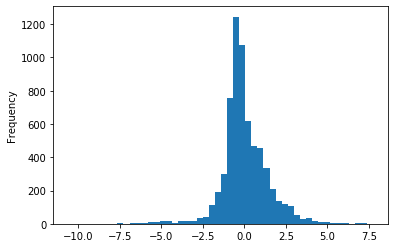

In [151]:
data2019['epa'].plot.hist(bins=50)

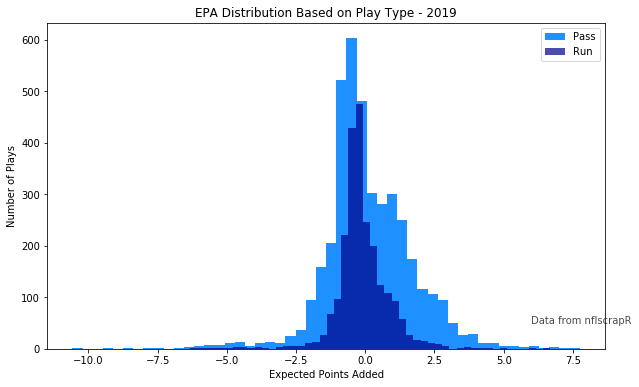

In [152]:
#Create figure and give it a number, enter in a figsize to modify size
plt.figure(1, figsize=(10,6))
#Place a histogram on the figure with the EPA of all pass plays, assign a label, choose a color
plt.hist(data2019['epa'].loc[data2019['play_type']=='pass'], bins=50, label='Pass', color='dodgerblue')
#Place a second histogram this time for rush plays, the alpha < 1 will make this somewhat transparent
plt.hist(data2019['epa'].loc[data2019['play_type']=='run'], bins=50, label='Run', alpha=.7, color='darkblue')
plt.xlabel('Expected Points Added')
plt.ylabel('Number of Plays')
plt.title('EPA Distribution Based on Play Type - 2019')
plt.text(6,50,'Data from nflscrapR', fontsize=10, alpha=.7)
#Will show the colors and labels of each histogram
plt.legend()
#Save the figure as a png
plt.savefig('epa_dist.png', dpi=400)
plt.show()

In [153]:
#use logo folder instead
#urls = pd.read_csv('https://raw.githubusercontent.com/statsbylopez/BlogPosts/master/nfl_teamlogos.csv')
#for i in range(0,len(urls)):
    #urllib.request.urlretrieve(urls['url'].iloc[i], os.getcwd() + '\\logos\\' + urls['team'].iloc[i] + '.png')

In [154]:
def getImage(path): 
    return OffsetImage(plt.imread(path), zoom=1)

In [155]:
logos = os.listdir(os.getcwd() + '\\logos\\')

logo_paths = []

for i in logos:
    logo_paths.append(os.getcwd() + '\\logos\\' + str(i))

In [156]:
#Make a new dataframe that contains pass success rate, grouped by team
success_rates = data2019.loc[data2019['play_type']=='pass'].groupby(by='posteam')[['success']].mean()

In [157]:
#Add in rushing success
success_rates['run_success'] = data2019.loc[data2019['play_type']=='run'].groupby(by='posteam')[['success']].mean()

In [158]:
#Relabel the columns 
success_rates.columns = [['pass_success','run_success']]

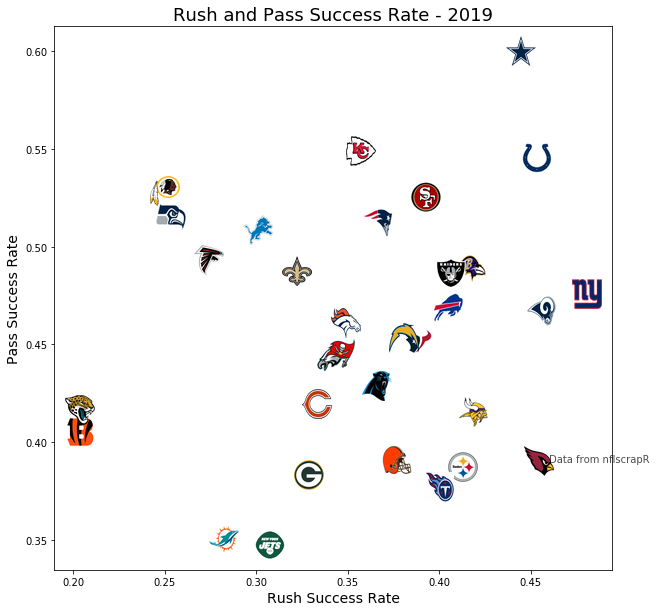

In [159]:
#Make x and y variables for success rate data
x = data2019.loc[data2019['play_type']=='run'].groupby(by='posteam')[['success']].mean().success.values
y = data2019.loc[data2019['play_type']=='pass'].groupby(by='posteam')[['success']].mean().success.values

#Create a figure with size 10x10
fig, ax = plt.subplots(figsize=(10,10))

#Make a scatter plot with success rate data
ax.scatter(x, y, s=.001)

#Adding logos to the chart
for x0, y0, path in zip(x, y, logo_paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False, fontsize=4)
    ax.add_artist(ab)

    #Adding labels and text
ax.set_xlabel('Rush Success Rate', fontsize=14)
ax.set_ylabel('Pass Success Rate', fontsize=14)
ax.set_title('Rush and Pass Success Rate - 2019', fontsize=18)
ax.text(.46, .39, 'Data from nflscrapR', fontsize=10, alpha=.7)

#Save the figure as a png
plt.savefig('2019-rush-pass-success.png', dpi=400)

In [160]:
data2019.insert(70, 'fg_success', 0)

In [161]:
data2019.loc[data2019['field_goal_result']=='made', 'fg_success'] = 1

In [162]:
data2019.insert(70, 'fg_attempt', 0)

In [163]:
data2019.loc[data2019['play_type']=='field_goal', 'fg_attempt'] = 1

In [164]:
#FG SUCCESS
fg_success = data2019.loc[data2019['play_type']=='field_goal'].groupby(by='home_team')[['fg_success']].mean()

In [165]:
#FG Attempts
fg_attempt = data2019.loc[data2019['play_type']=='field_goal'].groupby(by='home_team')[['fg_attempt']].count()

In [166]:
#Relabel the columns 
fg_success_rates.columns = [['fg_success_rates','fg_attempts']]

In [167]:
fg_success_rates

,fg_success_rates,fg_attempts
home_team,,
